# Proyecto Modelación y Simulación

#### Francis Aguilar 22243
#### Diego García    22404
#### Ángela García   22869

Usando un modelo basado en agentes, sobre una red sintética, se simulará el crecimiento y el colapso de una estafa piramidal, impulsada por el reclutamiento. Cada agente debería invertir o reclutar según su credibilidad y éxito local.

In [41]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [42]:
# params = {
#     "N_AGENTES": 500,
#     "GRADO_MEDIO": 3,
#     "NUM_PROMOTORES_INICIALES": 3,
#     "INVERSION": 100.0,
#     "RETORNO": 0.05,
#     "COMISION": 0.20,
#     "P_BASE": 0.25,
#     "PASOS_MAX": 100,
#     "PASOS_SIN_NUEVOS_PARA_COLAPSO": 8
# }

In [43]:
# Reproducibilidad
random.seed(42)
np.random.seed(42)

# Parámetros
params = {
    "N_AGENTES": 500,                          # Cantidad de agentes
    "GRADO_MEDIO": 3,                          # Conectividad de la red
    "NUM_PROMOTORES_INICIALES": 3,
    "INVERSION": 100.0,                        # Monto que invierte cada nuevo participante
    "RETORNO": 0.05,                           # Retorno prometido por periodo, según lo invertido
    "COMISION": 0.20,                          # Comisión para el reclutador, según la inversión del reclutado
    "P_BASE": 0.25,                            # Probabilidad inicial de convencer a otro
    "PASOS_MAX": 100,                          # Paso máximo de simulación
    "PASOS_SIN_NUEVOS_PARA_COLAPSO": 8,        # Cuántos pasos sin nuevos tonotos que se metan a la estafa para que colapse
    "LAG_PROMOTOR_VETERANO": 3,                # Pasos para ser "veterano"
    "MIN_FRACCION_PARTICIPANTES_PAGADOS": 0.3  # Porcentaje mínimo de participantes pagados para evitar colapso
}

In [44]:
# Crear la red sintética
G = nx.barabasi_albert_graph(
    n=params["N_AGENTES"],
    m=params["GRADO_MEDIO"]
)

# Inicializar atributos de los agentes
for n in G.nodes:
    G.nodes[n].update({
        "estado": "ignorante",      # "ignorante", "participante", "promotor"
        "credibilidad": np.random.uniform(0.2, 0.8),
        "invertido": 0.0,
        "ganancia": 0.0,            # ganancia neta
        "reclutados": 0,            # número de agentes que ha reclutado
        "paso_union": None,         # en qué paso entró a la estafa
        "reclutador": None          # quién lo reclutó
    })

# Escoger promotores iniciales de entre los agentes
promotores_iniciales = random.sample(list(G.nodes), params["NUM_PROMOTORES_INICIALES"])

for p in promotores_iniciales:
    G.nodes[p]["estado"] = "promotor"
    # El promotor inicial invierte para "activar" la estafa
    G.nodes[p]["invertido"] = params["INVERSION"]
    G.nodes[p]["ganancia"] = -params["INVERSION"]
    G.nodes[p]["paso_union"] = 0

# Estado global de la estafa
state = {
    "t": 0,
    "colapsado": False
}

# Historial para análisis
history = {
    "t": [],
    "n_participantes": [],
    "n_promotores": [],
    "n_promotores_veteranos": [],
    "n_participantes_normales": [],
    "n_nuevos": [],
    "total_invertido": [],
    "ganancia_total": [],
    "colapsado": []
}

# Metricas globales de cada paso
def registrar_estado():
    t = state["t"]

    # Participantes = todos los que están dentro de la estafa (participante o promotor)
    participantes = [
        n for n, a in G.nodes(data=True)
        if a["estado"] in ("participante", "promotor")
    ]

    # Promotores totales
    promotores = [
        n for n, a in G.nodes(data=True)
        if a["estado"] == "promotor"
    ]
    n_promotores = len(promotores)

    # Promotores veteranos
    veteranos = [
        n for n in promotores
        if G.nodes[n]["paso_union"] is not None
        and G.nodes[n]["paso_union"] <= t - params["LAG_PROMOTOR_VETERANO"]
    ]
    n_promotores_veteranos = len(veteranos)

    # Participantes "normales" (no promotores)
    n_participantes_normales = sum(
        1 for _, a in G.nodes(data=True)
        if a["estado"] == "participante"
    )

    total_invertido = sum(a["invertido"] for _, a in G.nodes(data=True))
    ganancia_total = sum(a["ganancia"] for _, a in G.nodes(data=True))

    history["t"].append(t)
    history["n_participantes"].append(len(participantes))
    history["n_promotores"].append(n_promotores)
    history["n_promotores_veteranos"].append(n_promotores_veteranos)
    history["n_participantes_normales"].append(n_participantes_normales)
    history["n_nuevos"].append(0)  # se sobrescribe en cada step()
    history["total_invertido"].append(total_invertido)
    history["ganancia_total"].append(ganancia_total)
    history["colapsado"].append(state["colapsado"])

# Registrar el estado inicial (t = 0)
registrar_estado()


In [45]:
# Probabilidad de reclutamiento
# Depende de la credibilidad del promotor y del éxito local
def prob_reclutamiento(promotor, vecino):
    a = G.nodes[promotor]
    vecinos_promotor = list(G.neighbors(promotor))
    exito_local = a["reclutados"] / max(1, len(vecinos_promotor))

    # Mezclamos factores: base * (1 + credibilidad) * (0.5 + éxito_local)
    p = params["P_BASE"] * (0.5 + a["credibilidad"]) * (0.5 + exito_local)
    return float(np.clip(p, 0.0, 1.0))

# Todo lo que ocurre en un paso de la simulación
def step():
    if state["colapsado"]:
        return  # No hacer nada si ya colapsó

    t = state["t"]
    nuevos = []

    # 1. Reclutamiento: cada promotor intenta convencer a vecinos ignorantes
    promotores = [n for n, a in G.nodes(data=True) if a["estado"] == "promotor"]

    for p in promotores:
        vecinos = list(G.neighbors(p))
        candidatos = [v for v in vecinos if G.nodes[v]["estado"] == "ignorante"]
        if not candidatos:
            continue

        for v in candidatos:
            p_recl = prob_reclutamiento(p, v)
            if np.random.rand() < p_recl:
                # El reclutado invierte
                G.nodes[v]["estado"] = "participante"
                G.nodes[v]["invertido"] = params["INVERSION"]
                G.nodes[v]["ganancia"] = -params["INVERSION"]
                G.nodes[v]["paso_union"] = t
                G.nodes[v]["reclutador"] = p
                nuevos.append(v)

                # Le da comisión al promotor
                G.nodes[p]["ganancia"] += params["COMISION"] * params["INVERSION"]
                G.nodes[p]["reclutados"] += 1

        # 2. Nuevos pagan a viejos,
        # priorizando promotores veteranos y un % mínimo de participantes.
        inversion_nueva = len(nuevos) * params["INVERSION"]

        participantes_previos = [
            n for n, a in G.nodes(data=True)
            if a["estado"] in ("participante", "promotor")
            and a["paso_union"] is not None
            and a["paso_union"] < t
        ]

        if participantes_previos and inversion_nueva > 0:
            # Separar promotores veteranos y resto de participantes
            veteranos = [
                n for n in participantes_previos
                if G.nodes[n]["estado"] == "promotor"
                and G.nodes[n]["paso_union"] <= t - params["LAG_PROMOTOR_VETERANO"]
            ]
            otros = [n for n in participantes_previos if n not in veteranos]

            pool = inversion_nueva  # dinero disponible para pagar retornos

            # ---- 2.1 Pagar primero a promotores veteranos (completo) ----
            costo_veteranos = params["RETORNO"] * sum(G.nodes[n]["invertido"] for n in veteranos)

            if costo_veteranos > 0:
                if pool >= costo_veteranos:
                    for n in veteranos:
                        inv = G.nodes[n]["invertido"]
                        pago = params["RETORNO"] * inv
                        G.nodes[n]["ganancia"] += pago
                    pool -= costo_veteranos
                else:
                    # ni siquiera alcanza para ellos → colapso
                    state["colapsado"] = True

            # ---- 2.2 Pagar a un porcentaje mínimo de los demás participantes ----
            if not state["colapsado"] and otros:
                n_otros = len(otros)
                n_min = int(np.ceil(params["MIN_FRACCION_PARTICIPANTES_PAGADOS"] * n_otros))

                # costo individual del retorno completo de cada uno
                otros_costos = [
                    (n, params["RETORNO"] * G.nodes[n]["invertido"])
                    for n in otros
                ]

                # Priorizar a los más antiguos
                otros_costos.sort(key=lambda x: G.nodes[x[0]]["paso_union"])

                pagados = []
                for n, costo in otros_costos:
                    if pool >= costo:
                        G.nodes[n]["ganancia"] += costo
                        pool -= costo
                        pagados.append(n)
                    else:
                        break

                # si no se logró pagar al porcentaje mínimo → colapso
                if len(pagados) < n_min:
                    state["colapsado"] = True


    # 3. Algunos participantes "exitosos" se vuelven promotores
    # El exito se mide por ganancia positiva y credibilidad alta
    if not state["colapsado"]:
        for n, a in G.nodes(data=True):
            if a["estado"] == "participante" and a["ganancia"] > 0 and a["credibilidad"] > 0.5:
                a["estado"] = "promotor"

    # 4. Actualizar credibilidad de promotores según si les va bien o mal
    for n, a in G.nodes(data=True):
        if a["estado"] == "promotor":
            if a["ganancia"] > 0 and len(nuevos) > 0 and not state["colapsado"]:
                a["credibilidad"] = min(1.0, a["credibilidad"] + 0.05)
            else:
                a["credibilidad"] = max(0.0, a["credibilidad"] - 0.05)

    # 5. Registrar métricas
    state["t"] += 1
    registrar_estado()
    history["n_nuevos"][-1] = len(nuevos)

    # 6. Revisa si se generó un colapso
    if len(history["n_nuevos"]) >= params["PASOS_SIN_NUEVOS_PARA_COLAPSO"]:
        ultimos = history["n_nuevos"][-params["PASOS_SIN_NUEVOS_PARA_COLAPSO"]:]
        if all(x == 0 for x in ultimos):
            state["colapsado"] = True
            history["colapsado"][-1] = True


In [46]:
# CORRE LA SIMULACIÓN
for _ in range(params["PASOS_MAX"]):
    if state["colapsado"]:
        break
    step()

print(f"Simulación terminada en t = {state['t']}")
print(f"¿La estafa colapsó? {state['colapsado']}\n\n")

# Valores finales desde el historial
n_prom_veteranos_final = history["n_promotores_veteranos"][-1]
n_normales_final = history["n_participantes_normales"][-1]

print(f"Promotores veteranos al final: {n_prom_veteranos_final}")
print(f"Participantes 'normales' al final: {n_normales_final}")


Simulación terminada en t = 23
¿La estafa colapsó? True


Promotores veteranos al final: 63
Participantes 'normales' al final: 129


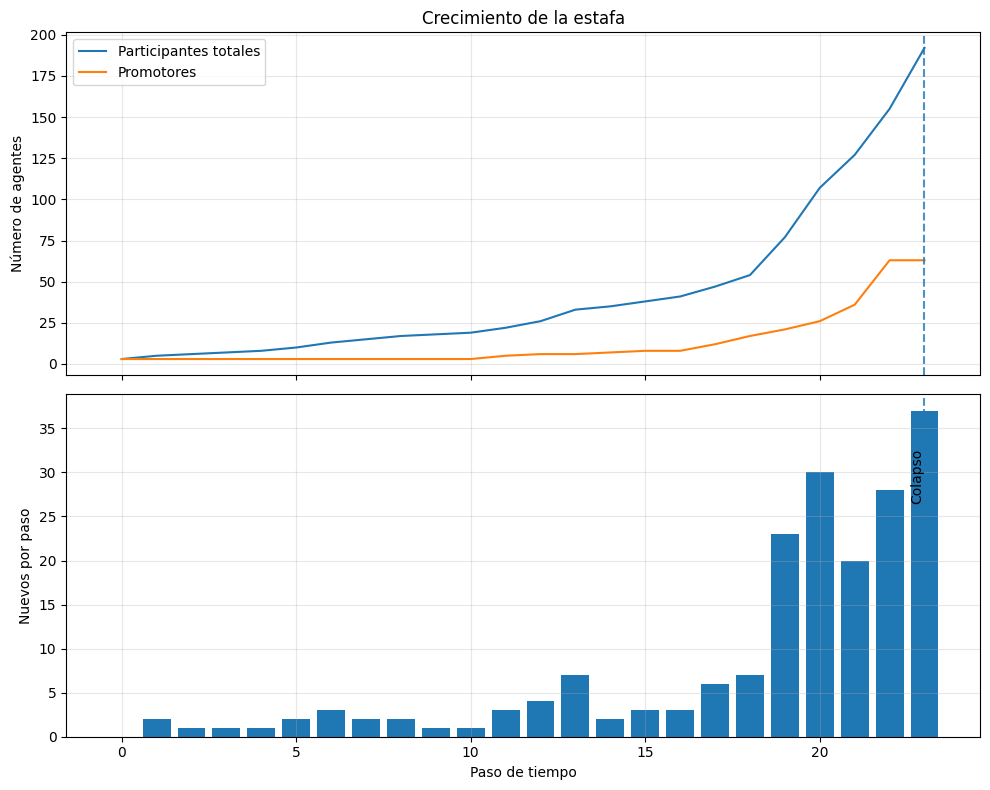

In [47]:
# Graficas de los resultados

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

t = history["t"]

# 1) Tamaño de la estafa
axes[0].plot(t, history["n_participantes"], label="Participantes totales")
axes[0].plot(t, history["n_promotores"], label="Promotores")
axes[0].set_ylabel("Número de agentes")
axes[0].set_title("Crecimiento de la estafa")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Flujo de nuevos inversores y colapso
axes[1].bar(t, history["n_nuevos"], label="Nuevos participantes por paso")
axes[1].set_ylabel("Nuevos por paso")
axes[1].set_xlabel("Paso de tiempo")
axes[1].grid(True, alpha=0.3)

# Marcar momento de colapso (si ocurrió)
if any(history["colapsado"]):
    t_colapso = next(tt for tt, c in zip(t, history["colapsado"]) if c)
    for ax in axes:
        ax.axvline(t_colapso, linestyle="--", alpha=0.8)
    axes[1].text(t_colapso, max(history["n_nuevos"] + [1]) * 0.8,
                 "Colapso", rotation=90, va="center", ha="right")

plt.tight_layout()
plt.show()

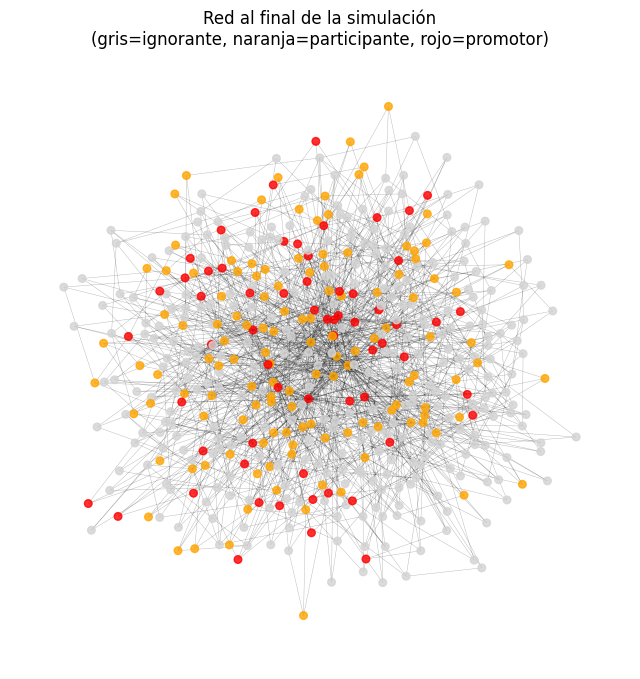

In [48]:
# ESTO SE VE COMO MUCHO SPAM Y NO SE SI DEJARLO XD

# Visualización final de la red
color_map = []
for n, a in G.nodes(data=True):
    if a["estado"] == "ignorante":
        color_map.append("lightgray")
    elif a["estado"] == "participante":
        color_map.append("orange")
    elif a["estado"] == "promotor":
        color_map.append("red")
    else:
        color_map.append("black")

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3)

plt.title("Red al final de la simulación\n(gris=ignorante, naranja=participante, rojo=promotor)")
plt.axis("off")
plt.show()